# Week 13 Handling Missing Values

For various reasons, many real world datasets contain missing values, often encoded as blanks, NaNs or other placeholders. Such datasets are usually incompatible with the operations we want to apply to it during the analysis.

In this section, we will discuss several common approaches for handling missing values:
- Discard imcomplete records
- Mean/median imputation
- Hot-deck imputation
- Missing value indicator
- Advanced imputation methods

Reading:
- Textbook, Chapter 7

**An Example Data Set**

The [Pima Indians Diabetes Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database) involves predicting the onset of diabetes within 5 years in Pima Indians given medical details.

It is a binary (2-class) classification problem. The number of observations for each class is not balanced. There are 768 observations with 8 input variables and 1 output variable. The variable names are as follows:

0. Number of times pregnant.
1. Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
2. Diastolic blood pressure (mm Hg).
3. Triceps skinfold thickness (mm).
4. 2-Hour serum insulin (mu U/ml).
5. Body mass index (weight in kg/(height in m)^2).
6. Diabetes pedigree function.
7. Age (years).
8. Class variable (0 or 1).

In [1]:
# Reference
# https://machinelearningmastery.com/handle-missing-data-python/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data set as a data frame named "data"
import zipfile

# After downloading "archive.zip" and saving it in the Data folder:
file = zipfile.ZipFile("Data/archive.zip", "r")
file.extractall("Data")
file.close()

data = pd.read_csv("Data/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


To save time, we will skip some routine steps such as checking the data types or the distributions.

In [3]:
# Show value counts of the outcomes

data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [4]:
# Check for the number of missing values
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In the following columns, a value of zero indicates a missing value:

- Plasma glucose concentration
- Diastolic blood pressure
- Triceps skinfold thickness
- 2-Hour serum insulin
- Body mass index

<AxesSubplot:>

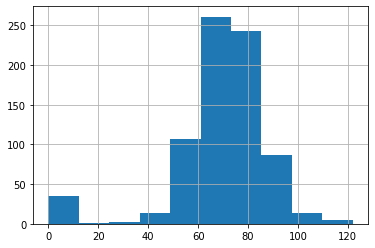

In [5]:
data['BloodPressure'].hist()

In [6]:
# We should mark missing values with np.nan, so that these values can be
# correctly ignored from operations such as sum, count, min, etc.
cols = list(data.columns)
cols.remove(cols[0]) # remove the preganicies column
cols.remove(cols[-1]) # remove the outcome column
print(cols)

for col in cols:
    for idx in data.index:
        if data.loc[idx, col] == 0:
            data.loc[idx, col] = np.nan

data.head()

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [7]:
# How many missing values are there for each feature?

data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [ ]:
data.info()

We can see that Glucose, BloodPressure, and BMI have just a few zero values, while SkinThickness and Insulin show nearly half of the rows missing.

## Approach 1: Discard Rows/Columns with Missing values

The simpliest strategy for handling missing data is to discard rows/columns that contain a missing value.

In [8]:
# Pandas provides the dropna() function that can be used to drop either columns or rows \
# with missing data.
data1 = data.dropna()
data1.shape # Only 392 rows are left. Too many rows were removed.

(392, 9)

In [ ]:
data1.shape # the size of dataset shrinked significantly

In [9]:
# Change axis paramter to drop columns containing missing values
data2 = data.dropna(axis=1)
data2.head(10) # too many useful features are removed

,Pregnancies,DiabetesPedigreeFunction,Age,Outcome
0,6,0.627,50,1
1,1,0.351,31,0
2,8,0.672,32,1
3,1,0.167,21,0
4,0,2.288,33,1
5,5,0.201,30,0
6,3,0.248,26,1
7,10,0.134,29,0
8,2,0.158,53,1
9,8,0.232,54,1


Removing rows with missing values may significantly reduce the number of rows, and thus hurt the quality of the dataset. This approach is only recommended if the number of missing values is small.

## Approach 2: Replace Missing Values with Mean or Median

The mean and median represent the "average" value of the column, and thus can be a reasonable guess on the missing values.

155.5482233502538


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.0,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,NaN,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1
5,5,116.0,74.0,NaN,155.548223,25.6,0.201,30,0
6,3,78.0,50.0,32.0,88.000000,31.0,0.248,26,1
7,10,115.0,NaN,NaN,155.548223,35.3,0.134,29,0
8,2,197.0,70.0,45.0,543.000000,30.5,0.158,53,1
9,8,125.0,96.0,NaN,155.548223,NaN,0.232,54,1


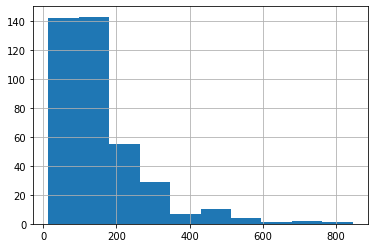

In [10]:
# Pandas provides fillna() function for replacing missing values with a 
# specific value.

# fill the insulin column with the mean value
data3 = data.copy() # raw_data will not be affected
data3['Insulin'].hist()
mean = data3['Insulin'].mean()
print(mean)
data3['Insulin'].fillna(mean, inplace=True)
data3.head(10)

In [11]:
data3.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                       0
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [12]:
# Perform mean imputation for all columns
data4 = data.copy()
data4.fillna(data4.mean(), inplace=True)
data4.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.000000,35.00000,155.548223,33.600000,0.627,50,1
1,1,85.0,66.000000,29.00000,155.548223,26.600000,0.351,31,0
2,8,183.0,64.000000,29.15342,155.548223,23.300000,0.672,32,1
3,1,89.0,66.000000,23.00000,94.000000,28.100000,0.167,21,0
4,0,137.0,40.000000,35.00000,168.000000,43.100000,2.288,33,1
5,5,116.0,74.000000,29.15342,155.548223,25.600000,0.201,30,0
6,3,78.0,50.000000,32.00000,88.000000,31.000000,0.248,26,1
7,10,115.0,72.405184,29.15342,155.548223,35.300000,0.134,29,0
8,2,197.0,70.000000,45.00000,543.000000,30.500000,0.158,53,1
9,8,125.0,96.000000,29.15342,155.548223,32.457464,0.232,54,1


In [13]:
data4.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

**Discussion:** 
1. When is median value preferred over the mean value?

When the distribution of data is skewed, the mean value usually will be influenced. In such cases, the median value is a better choice to represent a typical value from the column.


2. What are the limitations of mean/median imputation?
    - There will be less variation in the data.
    - If there are more than one peak in the distribution, the mean or median will not effectively represent the typical value.

In [14]:
# What is the median value of the insulin column?
data['Insulin'].median()

125.0

In [15]:
data['Insulin'].std()

118.77585518724514

In [16]:
data4['Insulin'].std()

85.02110776922125

## Approach 3: Hot Deck Imputation
**Hot deck imputation** is a method for handling missing data by replacing them with an random observed value. This imputation method preserves the variance of the dataset.

In [17]:
# Write a function that implements hot deck imputation for a column, and then
# use apply() to apply this function to the data frame


def hot_deck(x, col):
    """
    If the value x is missing, replace it with a randomly chosen value from col.
    """
    
    # If x is not NaN, then return x.
#     print("np.isnan(x):", np.isnan(x))
    if not np.isnan(x):
        return x
    else:
        col = col.dropna()
#         print("Number of missing values in col:", col.isnull().sum())
        return np.random.choice(col)
    
    

In [ ]:
# Test this function
hot_deck(data.loc[0, 'Insulin'], data['Insulin'])

In [18]:
# Apply this function to the Insulin column
data5 = data.copy()
data5["Insulin"] = data['Insulin'].apply(hot_deck, args=(data['Insulin'],))
data5.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,135.0,26.6,0.351,31,0
2,8,183.0,64.0,NaN,85.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [19]:
# Compare the standard deviation of imputed dataset and the original one.
data5["Insulin"].std()

123.22304805924796

In [ ]:
# np.isnan() can be used to detect a single missing value.
temp = np.nan
np.isnan(temp)

**Pros and Cons for Hot-Deck Imputation**:

+ It maintains a similar level of variance.
- It is achieved by a random selection, so individual imputations may be not very accurate.

**Advanced Usage:**

Approach 2 and 3 can be made more specific on which group each instance belongs to.

In [25]:
# Replace the missing Glucose values using the average value from people
# of the same age.
data6 = data.copy()
index = pd.isnull(data6['Glucose'])
data6[index]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,NaN,48.0,20.0,NaN,24.7,0.140,22,0
182,1,NaN,74.0,20.0,23.0,27.7,0.299,21,0
342,1,NaN,68.0,35.0,NaN,32.0,0.389,22,0
349,5,NaN,80.0,32.0,NaN,41.0,0.346,37,1
502,6,NaN,68.0,41.0,NaN,39.0,0.727,41,1


In [32]:
# Extract all the records with the same age:
# data[data['Age'] == 41]

# find the mean glucose for all the people with age 22
data6[data6['Age'] == 41]['Glucose'].mean()


135.23809523809524

In [27]:
data6['Glucose'].mean()

121.6867627785059

In [30]:
def guess_glucose(row, df):
    
    # If the Glucose value in row is not missing, then return this glucose value.
    if not np.isnan(row['Glucose']):
        return row['Glucose']
    # Else, extract all rows with the same age from df,
    # and return the average glucose value among these records.
    else:
        target_age = row['Age']
        sub_df = df[df['Age'] == target_age] # extract all records with the same age
        guess = sub_df['Glucose'].mean() # calculate the average glucose value
        return guess
    
#         return df[df['Age'] == row['Age']]['Glucose'].mean()

In [33]:
guess_glucose(data6.loc[502, :], data6)

135.23809523809524

<AxesSubplot:>

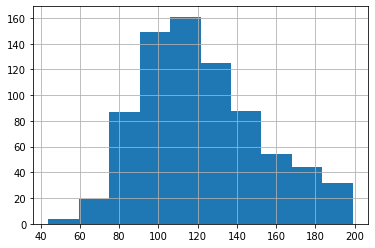

In [34]:
data6['Glucose'].hist() # The glucose values indeed clustered around the mean value

In [36]:
# Apply the function to the entire data frame
data6['Glucose'] = data6.apply(guess_glucose, args=(data6,), axis=1)
data6.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [ ]:
# Replace the missing BloodPressure value using a random value from people 
# of the same age.



## Approach 4: Add missing value indicator

We haven't yet discussed an importnant question: **What caused the missing values?** In general, there are three assumptions we may have:
- **Missing Completely at Random (MCAR)**: Values in a data set are missing completely at random (MCAR) if the events that lead to any particular data-item being missing are independent both of observable variables and of unobservable parameters of interest, and occur entirely at random.
- **Missing at Random (MAR)**: Missing at random (MAR) occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.
- **Missing not at random (MNAR)**: Missing not at random (MNAR) (also known as nonignorable nonresponse) is data where the value of the variable that's missing is related to the reason it's missing.

When the dataset is MNAR, one cannot simply predict the missing values using existing values. If this is likely the case, then a safe approach is to add an indicator feature of whether the corresponding value is missing.

In [37]:
# Create a boolean indicating whether the insulin value is missing or not
data7 = data.copy()
data7['InsulinMissing'] = data7['Insulin'].isnull().astype(int)
data7.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,InsulinMissing
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0,1
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0


## Approach 5: Use Predictive Machine Learning Model

Reference:
- [MICEFOREST](https://github.com/AnotherSamWilson/miceforest)

In [38]:
!pip install miceforest
# This the command below if the first one does not work:
# !pip install git+https://github.com/AnotherSamWilson/miceforest.git

  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


In [39]:
import miceforest as mf
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

# Load data and introduce missing values
iris = pd.concat(load_iris(as_frame=True,return_X_y=True),axis=1)
iris['target'] = iris['target'].astype('category')
iris_amp = mf.ampute_data(iris,perc=0.25,random_state=1991)

In [40]:
# Create kernel. 
kds = mf.KernelDataSet(
  iris_amp,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 3 iterations
kds.mice(3)

# Return the completed kernel data
completed_data = kds.complete_data()

In [41]:
completed_data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.0,3.5,1.4,0.2,0
1,4.4,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.1,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.3,3.0,5.1,2.3,2
